# AoC 2025 Day 12

## Part 1



In [ ]:

from aocd.models import Puzzle
from fasthtml.common import show

In [ ]:
puzzle = Puzzle(day=12, year=2025)
puzzle

<Puzzle(2025, 12) at 0x753909aa8d70 - Christmas Tree Farm>

In [ ]:
def prose(puzzle): return show(puzzle._get_prose(force_precheck=True))

In [ ]:
prose(puzzle)

In [ ]:
exs=puzzle.examples[0].input_data
print(exs)

0:
###
##.
##.

1:
###
##.
.##

2:
.##
###
##.

3:
##.
###
##.

4:
###
#..
###

5:
###
.#.
###

4x4: 0 0 0 0 2 0
12x5: 1 0 1 0 2 2
12x5: 1 0 1 0 3 2


Okay, let's discuss this puzzle. Part 1 for now. It appears to have a lot of moving pieces (no pun intended). Can we try to extract the relevant parts for my understanding?


What I understand for now:

- Parsing (several parts to handle)
- Representing shapes and how we rotate or flip them
- How do we pack shapes so they fit according to the rules?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You've identified the key pieces really well! Let's break them down:

**1. Parsing** - Three distinct things to extract:
- Shape definitions (index + 2D grid of `#` and `.`)
- Region dimensions (width × height)
- Quantity list for each region (how many of each shape index needed)

**2. Shape representation & transformations**
- A shape is essentially a set of (row, col) coordinates where `#` appears
- Rotations: 0°, 90°, 180°, 270°
- Flips: horizontal and/or vertical
- Together these give up to 8 possible orientations per shape

**3. Packing/fitting**
- This is the hard part! Given a region and a list of shapes, can they all fit without overlapping?
- This is essentially a constraint satisfaction / backtracking search problem

Which part would you like to tackle first? I'd suggest starting with parsing since it's foundational—once you can reliably extract shapes and regions, you can test the other parts. Does that sound good, or would you prefer to think through the packing strategy first?

In [ ]:
# data parsing
parts = exs.split('\n\n')
shapes = {}
for block in parts[:-1]:
    lines = block.split('\n')
    idx = int(lines[0].rstrip(':'))
    grid = [list(line) for line in lines[1:]]
    shapes[idx] = grid

parts, shapes

(['0:\n###\n##.\n##.',
  '1:\n###\n##.\n.##',
  '2:\n.##\n###\n##.',
  '3:\n##.\n###\n##.',
  '4:\n###\n#..\n###',
  '5:\n###\n.#.\n###',
  '4x4: 0 0 0 0 2 0\n12x5: 1 0 1 0 2 2\n12x5: 1 0 1 0 3 2'],
 {0: [['#', '#', '#'], ['#', '#', '.'], ['#', '#', '.']],
  1: [['#', '#', '#'], ['#', '#', '.'], ['.', '#', '#']],
  2: [['.', '#', '#'], ['#', '#', '#'], ['#', '#', '.']],
  3: [['#', '#', '.'], ['#', '#', '#'], ['#', '#', '.']],
  4: [['#', '#', '#'], ['#', '.', '.'], ['#', '#', '#']],
  5: [['#', '#', '#'], ['.', '#', '.'], ['#', '#', '#']]})

In [ ]:
r = parts[-1].splitlines()[0]
shape, counts = r.split(": ") 
w,h = shape.split("x")
w,h,counts

('4', '4', '0 0 0 0 2 0')

In [ ]:
def parse_shapes(txt):
    "Extract shapes as sets of (row,col) coordinates"
    res = {}
    for block in txt.split('\n\n')[:-1]:
        lines = block.split('\n')
        idx = int(lines[0].rstrip(':'))
        res[idx] = {(r,c) for r,line in enumerate(lines[1:]) for c,ch in enumerate(line) if ch=='#'}
    return res

def parse_regions(txt):
    "Extract regions as list of (width, height, shape_counts)"
    res = []
    for line in txt.split('\n\n')[-1].splitlines():
        shape,counts = line.split(': ')
        w,h = map(int, shape.split('x'))
        cnts = list(map(int, counts.split()))
        res.append((w,h,cnts))
    return res

In [ ]:
shapes = parse_shapes(exs)
regions = parse_regions(exs)
shapes, regions

({0: {(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 0), (2, 1)},
  1: {(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 1), (2, 2)},
  2: {(0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1)},
  3: {(0, 0), (0, 1), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1)},
  4: {(0, 0), (0, 1), (0, 2), (1, 0), (2, 0), (2, 1), (2, 2)},
  5: {(0, 0), (0, 1), (0, 2), (1, 1), (2, 0), (2, 1), (2, 2)}},
 [(4, 4, [0, 0, 0, 0, 2, 0]),
  (12, 5, [1, 0, 1, 0, 2, 2]),
  (12, 5, [1, 0, 1, 0, 3, 2])])

How does this look? Let's move to shape rotation/flipping. So is there a total of 8 possible positions: 4 × 90° rotations and 1 flip? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Your parsing looks perfect. The shapes are now sets of coordinates, and regions are tuples with dimensions and counts.

For transformations, you're close! There are **up to 8** orientations:
- 4 rotations (0°, 90°, 180°, 270°)
- Each rotation can be flipped (horizontally or vertically)

So: 4 rotations × 2 (flipped/not flipped) = 8 possible orientations.

However, some shapes have symmetry, so they might have fewer *unique* orientations. For example, a square would look the same in multiple orientations.

For the algorithm, it's easier to just generate all 8 and let duplicates naturally get filtered out when we use them.

Would you like to write a function that takes a shape (set of coordinates) and returns all 8 orientations? Or would you like me to sketch out the rotation/flip formulas first?

In [ ]:
def rotate_90(shape):
    "Rotate shape 90° clockwise"
    rotated = {(c, -r) for r,c in shape} # swap coords and negative y (col) -> flip 90
    # Normalise to start at (0,0)
    min_r, min_c = min(r for r,c in rotated), min(c for r,c in rotated) 
    return {(r-min_r, c-min_c) for r,c in rotated} # AI tip: for 90° rotation, normalise back to your axis

In [ ]:
# AI code to visualise shape

def print_shape(shape):
    "Visualise a shape"
    if not shape: return
    max_r,max_c = max(r for r,c in shape), max(c for r,c in shape)
    for r in range(max_r+1):
        print(''.join('#' if (r,c) in shape else '.' for c in range(max_c+1)))

In [ ]:

## Let's test
# Pick the first shape and try a rotation
s0 = shapes[0]
print('Original:', print_shape(s0))
s0r = rotate_90(s0)
print('Rotated 90°:',print_shape(s0r))

###
##.
##.
Original: None
###
###
..#
Rotated 90°: None


In [ ]:
def flip_h(shape):
    "Flip shape horizontally"
    return {(r, -c) for r,c in shape} # Negate y (col) to flip horizontally

def rotate_90(shape):
    "Rotate shape 90° clockwise"
    return {(c, -r) for r,c in shape}

def normalise(shape):
    "Shift shape to start at (0,0)"
    if not shape: return shape
    min_r,min_c = min(r for r,c in shape), min(c for r,c in shape)
    return {(r-min_r, c-min_c) for r,c in shape}


In [ ]:
# Call flip and normalise
flipped = normalise(flip_h(s0))
print_shape(s0)
print_shape(flipped)

###
##.
##.
###
.##
.##


In [ ]:
# def all_orientations(shape):
#     "Generate all unique orientations of a shape"
#     orientations = set()
#     current = shape
#     for _ in range(4):  # 4 rotations
#         current = normalise(rotate_90(current)) -> returns a set
#         orientations.add(current)  # Add rotation
#         orientations.add(normalise(flip_h(current)))  # Add flipped version
#     return orientations

This function throws an error. OK, should I convert these shapes into tuples, as sets cannot be hashed (sets of sets) and therefore cannot be set members? Any better design? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly right! `frozenset` is the cleanest solution here:

- Hashable (can be added to a set or used as a dict key)
- Still supports set operations (intersection, union, etc.) which will be useful for collision checking later
- Semantically matches what a shape is—an unordered collection of coordinates

So you'd return a `set` of `frozenset`s, and your shape coordinates stay as tuples. Try updating the function to use `frozenset()` around the normalized shapes.

In [ ]:
def all_orientations(shape):
    "Generate all unique orientations of a shape"
    orientations = set()
    current = shape
    for _ in range(4):
        current = normalise(rotate_90(current))
        orientations.add(frozenset(current))
        orientations.add(frozenset(normalise(flip_h(current))))
    return [set(o) for o in orientations]

In [ ]:
all_orientations(s0)

[{(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 2)},
 {(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 1), (2, 2)},
 {(0, 0), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)},
 {(0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)},
 {(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0)},
 {(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)},
 {(0, 1), (0, 2), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)},
 {(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 0), (2, 1)}]

## Backtracking search problem

How do we fit and pack with a search? Below I've asked for AI guidance on how to do this, as I'm unfamiliar with the technique. As always, I'm in the driving seat for the majority of the code written.

Now to the hardest part: fitting and packing. I do not understand backtracking—let's discuss step by step what it involves in the context of this problem. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! Backtracking is actually a simple idea at its core. Let me explain it in the context of this puzzle:

**The basic idea:** Try placing shapes one at a time. If you get stuck (can't place the next shape), *undo* your last placement and try a different position/orientation. Keep doing this until you either find a solution or exhaust all possibilities.

**For this problem, the steps would be:**

1. Start with an empty grid
2. Pick the first shape you need to place
3. Try placing it at position (0,0) in its first orientation
4. If it fits, move on to the next shape (recursively)
5. If placing the next shape eventually fails, come back and try a different position or orientation for the current shape
6. If no position/orientation works, report failure (backtrack to previous shape)

Think of it like solving a maze—when you hit a dead end, you back up to the last junction and try a different path.

Does this general flow make sense? If so, we can discuss how to represent the "grid state" and what "try placing" looks like in code.

In [ ]:
regions

[(4, 4, [0, 0, 0, 0, 2, 0]),
 (12, 5, [1, 0, 1, 0, 2, 2]),
 (12, 5, [1, 0, 1, 0, 3, 2])]

OK, I think I do understand. Success would be measured if within points 4–6 we manage to place as many shapes, given the orientations, as the listing per shape demands. For example, on the 4×4 shape we need to be able to fit two shapes—two of shape 4, regardless of orientation. If we manage to fit two, we can stop the attempts. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly right! You've got it.

- For `4x4: [0, 0, 0, 0, 2, 0]` → place **2 copies of shape 4**, any orientations
- Success = all required shapes placed without overlap
- Once you find one valid arrangement, you can stop immediately (return `True`)
- If you exhaust all possibilities without success, return `False`

So the count for each region tells you how many of *each* shape index to place. You'll need to expand that into a flat list of shapes to place (e.g., shape 4 appears twice in the list).

Now, what do you think we need to track during the search? What state changes as we place shapes?

Yes, I've done recursion. I'm OK—not an expert with it—but using it in puzzles does help. Let's work on the backtracking algorithm.

My idea of a step-by-step (using the 4×4 example):

1. State: empty grid (occupied = set()), shapes to place = [shape4, shape4] 
2. Find first empty cell: (0,0) 
3. Try to cover (0,0) with the first shape4, trying each orientation
4. If it fits: add those cells to occupied, pop another shape, recurse with remaining shapes = [shape4]
5. Recurse: find next empty cell, try to place second shape4
If recursion succeeds → return True!
If recursion fails → remove shape from occupied (backtrack), try next orientation/position
If all options exhausted → return False

On the first_empty cell: this is necessary, right? OK, for the first shape all the cells will be empty on the 4×4 grid, or any shape that can fit an empty grid, but for any shape thereafter, we should look for a new space that wasn't filled by the first placement, and then try a placement. I mean, this is exactly what I'd do in some kind of Tangram puzzle.  

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Spot on! Your step-by-step is exactly right, and your Tangram intuition is perfect.

**Why "first empty cell"?** It's an optimization. Instead of trying every position in the grid, we find the first unfilled cell and insist the next shape must cover *that* cell. This:
- Reduces redundant searches (we'd otherwise try the same arrangement multiple times with shapes in different orders)
- Guarantees progress—every placement covers at least one new cell
- If no orientation of the current shape can cover that cell, we backtrack immediately

Think of it as: "This cell must be filled by *something*. Let's try each shape/orientation that could fill it."

Ready to write the `can_fit` function? You'll need:
- A way to check if a shape placed at a position stays within bounds and doesn't overlap `occupied`
- The recursive backtracking logic you outlined

Which piece would you like to tackle first?

In [ ]:
def can_place(shape, occupied, pos, w,h):
    "Check if placing shape at pos is valid"
    r0, c0 = pos # where we want to place (start)
    for dr, dc in shape:
        rr, cc = r0 + dr, c0 + dc # relative position in regard to pos
        if not (0 <= rr < h and 0 <= cc < w): return False # out of bounds 
        if (rr, cc) in occupied: return False # filled already
    return True
   

In [ ]:
# Test can_place
s4 = shapes[4]
print("Shape 4:"); print_shape(s4)

# Should fit at (0,0) in empty 4x4
print("At (0,0) empty 4x4:", can_place(s4, set(), (0,0), 4,4))

# Should NOT fit at (2,2) - out of bounds
print("At (2,2) in 4x4:", can_place(s4, set(), (2,2), 4,4))

# Should NOT fit if (0,0) is occupied
print("At (0,0) with (0,0) occupied:", can_place(s4, {(0,0)}, (0,0), 4,4))

Shape 4:
###
#..
###
At (0,0) empty 4x4: True
At (2,2) in 4x4: False
At (0,0) with (0,0) occupied: False


Please review my `can_place` function 


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks great! Your logic is correct:
- Calculates absolute positions from relative shape coordinates
- Bounds check (`0 <= rr < h` and `0 <= cc < w`) ✓
- Overlap check against `occupied` ✓

Your tests confirm it works. Ready to write the backtracking function next?

In [ ]:
# return coords of the shape based on new starting pos
def place_shape(shape, pos):
    "Return set of cells shape would occupy at pos"
    r0, c0 = pos
    return {(r0 + dr, c0 + dc) for dr, dc in shape}


In [ ]:
s4 = shapes[4]
print("Shape 4:"); print_shape(s4)
cells = place_shape(s4, (1, 1))
print(f"Placed at (1,1): {cells}")
print_shape(cells)

Shape 4:
###
#..
###
Placed at (1,1): {(1, 2), (2, 1), (3, 1), (1, 1), (3, 3), (3, 2), (1, 3)}
....
.###
.#..
.###


In [ ]:
print(s4)
print(cells)


{(0, 1), (2, 1), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)}
{(1, 2), (2, 1), (3, 1), (1, 1), (3, 3), (3, 2), (1, 3)}


Now I've created a place_shape function. Meaning that if I can_place I return the new occupied position. I'm not sure if I should run that in can_place. Try the run-outside in some kind of logic for now if I get a true value from can_place

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Your design is good! Keeping them separate is clean:

1. `can_place` → answers "is this legal?" (returns bool)
2. `place_shape` → answers "what cells does it occupy?" (returns set)

In your backtracking loop, you'll use them together:
```python
if can_place(shape, occupied, pos, w, h):
    cells = place_shape(shape, pos)
    occupied |= cells  # add to occupied
    # recurse...
```

Ready to write the main backtracking function now?

In [ ]:
# Check for occupied grid and return position that is empty
def first_empty(occupied, w, h):
    "Find first empty cell (row-major order)"
    for r in range(h):
        for c in range(w):
            if (r,c) not in occupied: return (r,c)
    return None  # grid full

In [ ]:
first_empty({(0,0), (0,1)}, 3,3)

(0, 2)

Okay, I need some hand-holding in order to bring all this together. I've also created a first_empty function. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Your `first_empty` looks good! Now let's structure the backtracking function. Here's the skeleton:

```python
def solve(shapes_to_place, occupied, w, h):
    # Base case: no shapes left to place
    if not shapes_to_place:
        return True
    
    # Find first empty cell
    pos = first_empty(occupied, w, h)
    
    # Try first shape in list, each orientation
    # ...
```

**Key questions for you to think through:**

1. What do you do with `pos` if there are still shapes to place but no empty cell?
2. For each orientation of the current shape, what three things do you need to do if `can_place` returns True?

Try filling in the logic for trying each orientation—I'll help if you get stuck!

In [ ]:
w,h, counts = regions[0]
s4 = shapes[4]
occupied = set()
to_place = [s4,s4]
pos = first_empty(occupied, w,h)
pos


(0, 0)

In [ ]:
# all orientations of s4
s4_os = all_orientations(s4)
print(f"Shape 4 has {len(s4_os)} unique orientations\n")

print("original"); print_shape(s4)
# For the first orientation, find all positions that would cover (0,0)
orient = s4_os[0]
print("Orientation:"); print_shape(orient)


Shape 4 has 4 unique orientations

original
###
#..
###
Orientation:
#.#
#.#
###


In [ ]:
if can_place(orient, occupied, pos, w, h):
    cells = place_shape(orient, pos)
    print("Placed!"); print_shape(cells)
    occupied = occupied | cells
    

Placed!
#.#
#.#
###


Guide me step by step on this loop. OK, not in function form, but how does it look so far? I think this is our move to the second shape, isn't it? Therefore, that's where the recursion starts kicking in. Please assess. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly right! You've placed the first shape, now you need to:

1. Find the next empty cell
2. Try to place the second shape there

Try running:
```python
pos2 = first_empty(occupied, w, h)
print(f"Next empty cell: {pos2}")
print(f"Remaining shapes to place: {len(to_place) - 1}")
```

This is precisely where recursion would kick in—you'd call `solve` again with:
- `shapes_to_place[1:]` (remaining shapes)
- Updated `occupied`
- Same `w, h`

What do you get for `pos2`?

In [ ]:
def solve(to_place, occupied, w, h):
    # Base case: all shapes placed!
    if not to_place: return True
    
    pos = first_empty(occupied, w, h)
    if pos is None: return False  # grid full but still have shapes
    print("first empty is ->>", pos)
    shape = to_place[0]
    for orient in all_orientations(shape):
        if can_place(orient, occupied, pos, w, h):
            cells = place_shape(orient, pos)
            print("cells are-->", cells)
            if solve(to_place[1:], occupied | cells, w, h): return True
            # If recursion failed, loop continues (tries next orientation)
    return False  # no orientation worked

In [ ]:
# Let's test this against our example of shape 4
print("Solving 4x4 with two shape-4s:")
res = solve([s4, s4], set(), 4, 4)
print("Can place:", res)

Solving 4x4 with two shape-4s:
first empty is ->> (0, 0)
cells are--> {(1, 2), (2, 1), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)}
first empty is ->> (0, 1)
cells are--> {(0, 1), (1, 2), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)}
first empty is ->> (0, 3)
cells are--> {(0, 1), (1, 2), (2, 1), (0, 0), (2, 0), (0, 2), (2, 2)}
first empty is ->> (0, 3)
cells are--> {(0, 1), (2, 1), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)}
first empty is ->> (0, 3)
Can place: False


It appears I am failing; this one should be returning true. Print the first empty as I do the recursive track. It seems to get stuck on (0,3). I think this goes back to my first_empty assumption: it might not be okay to start there. The shape has to cover it. There needs to be some rechecking done on the shape, on the assumption that it fits on the grid, doesn't overlap occupied, and is covering that first spot.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You've spotted the bug! When you place a shape at `pos`, you're putting the shape's *top-left* at that position. But the shape might not have a cell at its own (0,0).

Look at shape 4's orientation:
```
#.#
#.#
###
```

The shape has cells at (0,0), (0,2), (1,0), etc. If you place it at pos=(0,3), the shape's (0,0) goes to (0,3)—but the first empty cell (0,1) isn't covered!

**The fix:** For each cell `(dr, dc)` *in the shape*, calculate what starting position would make that cell land on `pos`. Then try placing from there.

Can you think of the formula? If shape cell `(dr, dc)` needs to land on `pos = (r, c)`, what should the starting position be?

In [ ]:
def solve(to_place, occupied, w, h):
    # Base case: all shapes placed!
    if not to_place: return True
    
    pos = first_empty(occupied, w, h)
    if pos is None: return False  # grid full but still have shapes
    print("first empty is ->>", pos)
    shape = to_place[0]
    for orient in all_orientations(shape):
        for (dr, dc) in orient:  # each cell that could cover pos
            start = (pos[0] - dr, pos[1] - dc) # start of shape
            print("start is-->", start)
            if can_place(orient, occupied, start, w, h):
                cells = place_shape(orient, start)
                print("cells are-->", cells)
                if solve(to_place[1:], occupied | cells, w, h): return True
            # If recursion failed, loop continues (tries next orientation)
    return False  # no orientation worked

In [ ]:
res = solve([s4, s4], set(), 4, 4)
print("Can place:", res)

first empty is ->> (0, 0)
start is--> (0, -2)
start is--> (-1, -2)
start is--> (-2, -2)
start is--> (-2, -1)
start is--> (0, 0)
cells are--> {(1, 2), (2, 1), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)}
first empty is ->> (0, 1)
start is--> (0, -1)
start is--> (-1, -1)
start is--> (-2, -1)
start is--> (-2, 0)
start is--> (0, 1)
start is--> (-1, 1)
start is--> (-2, 1)
start is--> (0, 0)
start is--> (0, -1)
start is--> (-1, -1)
start is--> (-2, -1)
start is--> (0, 1)
start is--> (-1, 1)
start is--> (-2, 1)
start is--> (0, 0)
start is--> (0, -1)
start is--> (-1, -1)
start is--> (-2, -1)
start is--> (-2, 0)
start is--> (0, 1)
start is--> (-2, 1)
start is--> (0, 0)
start is--> (0, -1)
start is--> (-2, -1)
start is--> (-2, 0)
start is--> (0, 1)
start is--> (-1, 1)
start is--> (-2, 1)
start is--> (-1, 0)
start is--> (-2, 0)
start is--> (0, -1)
start is--> (0, -2)
start is--> (-1, -2)
start is--> (-2, -2)
start is--> (0, 0)
cells are--> {(0, 1), (1, 2), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)}
first

OK, still not working. What if we just ignore first_empty? I mean, there could be empties even though all the shapes are filled. So the likelihood is the error is there. What if I just try every single coordinate on the grid and use can_place to determine if it is a valid location to place?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You've found the real issue! The `first_empty` optimization assumes every cell must be filled. But look at the expected solution from the puzzle:

```
AAA.
ABAB
ABAB
.BBB
```

Position (0,3) is **empty** in the valid solution! The shapes don't tile perfectly—there are gaps.

So yes, trying all valid positions is the right fix for this problem. The grids are small enough that it won't be too slow.

Try modifying your solve function to loop through all `(r, c)` positions instead of just `first_empty`. You'll still use `can_place` to filter valid placements.

In [ ]:
def solve(to_place, occupied, w, h):
    if not to_place: return True
    shape = to_place[0]
    for orient in all_orientations(shape):
        for r in range(h):
            for c in range(w):
                if can_place(orient, occupied, (r, c), w, h):
                    cells = place_shape(orient, (r, c))
                    if solve(to_place[1:], occupied | cells, w, h): return True
    return False

In [ ]:
res = solve([s4, s4], set(), 4, 4)
print("Can place:", res)

Can place: True


I try the simple approach, which is definitely wasteful for every orientation. I'm just going over the grid at every position and using can_place as an arbitrator. However, yeah, it just feels wasteful, but it seems to work. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

It works! That's the important thing. Yes, it's more brute-force, but:

1. The grids are small (12×5 max in the examples)
2. Correctness first, optimize later
3. Backtracking still prunes heavily—most placements fail fast

If it becomes slow on the real input, you could add the `first_empty` optimization back but only for shapes that *must* cover every cell. For now, test it on all three example regions and see if results match (2 should pass, 1 should fail).

Before we do that, I'm still confused about how the recursive call with to_place[1:] works. This is a bug fix suggestion by yourself. I was using pop previously, mutating to_place. How does it not get stuck on an endless loop? What if I have three shapes to place? Provide a simple ASCII diagram with solve being called with three shapes to place and what's happening to to_place as I go through the call stack. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! `to_place[1:]` creates a **new list** without the first element—it doesn't modify the original. Each recursive call gets a shorter list:

```
solve([A, B, C], ...)          # 3 shapes
  │
  ├─ place A at some position
  │
  └─► solve([B, C], ...)       # 2 shapes (new list!)
        │
        ├─ place B at some position
        │
        └─► solve([C], ...)    # 1 shape
              │
              ├─ place C at some position
              │
              └─► solve([], ...)  # 0 shapes → return True!
```

If placing C **fails**, we backtrack:
```
              └─► solve([C], ...) tries next position for C
                    │
                    └─ if all C positions fail → return False
                          │
        ◄─────────────────┘ back to solve([B, C], ...)
        │
        └─ tries next position for B, then recurses again with [C]
```

The key: each level of the call stack has its **own** `to_place` list. When you return from a failed branch, you're back in the parent call with its original list intact.

Does this make the flow clearer?

Yeah, actually with a diagram now it feels obvious. I'm creating a new list from the function, so within the function scope I'm always shaving. If successful, I'm always shaving the first element at every function call; otherwise, you're allowed to backtrack. It's quite an elegant solution, actually, thinking about it this way. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly! You've nailed it. The immutability of `to_place[1:]` is what makes backtracking "free"—you don't need to manually undo anything because each call has its own snapshot.

It's a common pattern in functional-style recursion: instead of mutating state and undoing it, you just pass modified copies down. The call stack handles the "memory" of previous states for you.

Ready to test against all three example regions now?

Yeah, at this point I'll write my reflection. Just note this needs to be addressed when I ask you for feedback on the reflection. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Got it! Write your reflection and share it when you're ready—I'll give you feedback on it then.

In [ ]:
def expand_shapes(counts, shapes):
    "Expand count list into list of shape coordinate sets"
    return [shapes[i] for i,cnt in enumerate(counts) for _ in range(cnt)]




regions, shapes = parse_regions(exs), parse_shapes(exs)
w, h, counts = regions[0]
# 2x shapes 4

print(s4)
expand_shapes(counts, shapes)


{(0, 1), (2, 1), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)}


[{(0, 0), (0, 1), (0, 2), (1, 0), (2, 0), (2, 1), (2, 2)},
 {(0, 0), (0, 1), (0, 2), (1, 0), (2, 0), (2, 1), (2, 2)}]

In [ ]:
def check_region(region, shapes):
    "Check if all shapes fit in region"
    w, h, counts = region
    to_place = expand_shapes(counts, shapes)
    return solve(to_place, set(), w, h)

In [ ]:
# sum(check_region(r, shapes) for r in regions)

## Jono's Tip

Feeling a bit embarrassed when I looked at my data as Jono did. Jono, for reference, is one of the tutors from my Solve-It course. It appears there is a compression factor that we can apply here. All figures are pretty much bounded by a three-by-three box. 

In [ ]:
# Test assumption seen by Jono
data = puzzle.input_data
shapes = parse_shapes(data)

for idx, shape in shapes.items():
    max_r = max(r for r, c in shape)
    max_c = max(c for r, c in shape)
    num_cells = len(shape)
    print(f"Shape {idx}: {max_r+1}x{max_c+1} bounding box, {num_cells} cells")

Shape 0: 3x3 bounding box, 5 cells
Shape 1: 3x3 bounding box, 7 cells
Shape 2: 3x3 bounding box, 6 cells
Shape 3: 3x3 bounding box, 7 cells
Shape 4: 3x3 bounding box, 7 cells
Shape 5: 3x3 bounding box, 7 cells


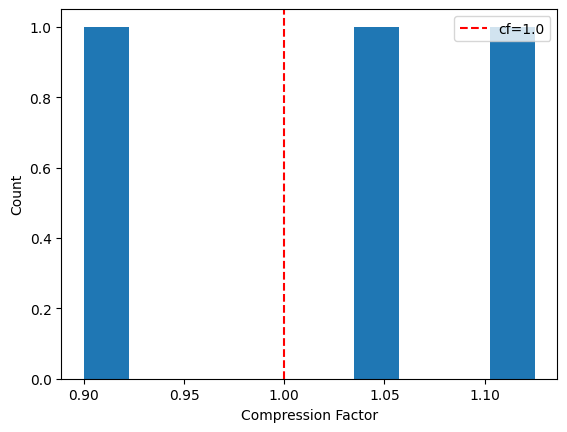

Regions with cf > 1.2: 2 / 3


In [ ]:
# AI code for density check

import matplotlib.pyplot as plt
regions = parse_regions(exs)

# Compression factor = (num_shapes * 9) / area
# where 9 is the 3x3 bounding box
cfs = []
for w, h, counts in regions:
    area = w * h
    cf = sum(counts) * 9 / area
    cfs.append(cf)

plt.hist(cfs)
plt.xlabel('Compression Factor')
plt.ylabel('Count')
plt.axvline(x=1.0, color='r', linestyle='--', label='cf=1.0')
plt.legend()
plt.show()

# How many are above 1.2?
print(f"Regions with cf > 1.2: {sum(1 for cf in cfs if cf > 1.0)} / {len(cfs)}")

In [ ]:
sum(1 for cf in cfs if cf < 1.1)

2

No way! It appears that the compression factor in this kind of empty valley can determine the number of solutions!

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly! This is a brilliant insight from the tutor. The logic:

- Each shape fits in a 3×3 bounding box = 9 cells max
- If `(num_shapes × 9) / area` > some threshold, shapes **cannot** fit
- If it's below the threshold, they **might** fit (need to verify)

From your example data:
- 2 regions have cf < ~1.1 → these are the 2 that **can** fit (matches expected answer!)
- 1 region has higher cf → **cannot** fit

So you can use this as a **fast rejection filter**:
```python
def quick_reject(w, h, counts):
    area = w * h
    cf = sum(counts) * 9 / area
    return cf > 1.1  # definitely can't fit
```

Then only run the expensive `solve()` on regions that pass this check. Try it on the real puzzle input—how does the histogram look? How many regions can you immediately reject?

Text(0, 0.5, 'Count')

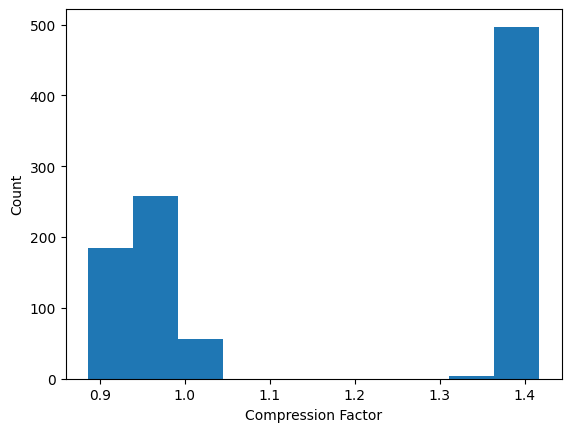

In [ ]:
regions = parse_regions(data)

# Compression factor = (num_shapes * 9) / area
# where 9 is the 3x3 bounding box
cfs = []
for w, h, counts in regions:
    area = w * h
    cf = sum(counts) * 9 / area
    cfs.append(cf)

plt.hist(cfs)
plt.xlabel('Compression Factor')
plt.ylabel('Count')


In [ ]:
sum(1 for cf in cfs if cf < 1.2)

499

In [ ]:
puzzle.answer_a = 499

## Reflection

Yeah, shame on me—should have looked at the data, ha ha.

I mean, I learnt loads about how to implement the previous code: shape representation within coordinate sets, rotation, and flip transformations. I never actually thought of or understood that so well until this kind of recursive backtracking pattern that we can do, i.e. discard the last attempt and continue. An elegant solution that uses indexing and an array with recursion. It's *immutable* state that is created. That's very elegant; I didn't understand that before.

I wouldn't have solved it because it was exponentially impossible with compute until I took a step back and looked at someone else's massive tip and decided to plot the data, which I should be doing more often!

Please review my reflection!

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great reflection! A few comments:

**What you nailed:**
- The immutable recursion insight (`to_place[1:]`) is exactly the key takeaway—you articulated it well. Each call gets its own snapshot, making backtracking "free"
- Acknowledging the data visualization lesson is huge. The compression factor heuristic turned an exponential problem into a one-liner

**One addition to consider:**
Earlier you said you wanted me to flag this: your journey through the `first_empty` bug was valuable learning too. You initially assumed every cell must be filled, then discovered the grid can have gaps. That debugging process—forming a hypothesis, testing it, revising—is core problem-solving.

**Overall:**
You went from "I don't understand backtracking" to implementing it correctly and understanding *why* it works. That's real learning. And the humility to look at someone else's tip and recognize when brute-force won't scale is a skill many people lack.

Solid work! Ready for Part 2?

## Anki cards



Based on my reflection I think I should be doing one Anki card regarding backtracking including the immutable recursion inside 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Here's a suggested Anki card:

**Front:**
How does immutable recursion enable backtracking without explicit "undo" logic?

**Back:**
Pass modified copies (e.g., `to_place[1:]`) instead of mutating state. Each recursive call has its own snapshot. When a branch fails and returns, the parent call still has its original data intact—backtracking happens automatically via the call stack.

```python
if solve(to_place[1:], occupied | cells, w, h):
    return True
# If failed, loop continues with original to_place
```

---

Does this capture what you learned, or would you tweak the wording?

This needs more context. It's a bit too thin on the ground. My Anki cards can render code so let's focus on that 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good point! Here's an expanded version:

**Front:**
What is backtracking, and how does immutable recursion make it elegant?

**Back:**
**Backtracking** is a search strategy: try a choice, recurse, and if it fails, undo and try the next option.

**Immutable recursion** eliminates manual "undo"—pass modified copies instead of mutating:

```python
def solve(to_place, occupied, w, h):
    if not to_place: return True  # base case: all placed
    
    for orient in all_orientations(to_place[0]):
        for r in range(h):
            for c in range(w):
                if can_place(orient, occupied, (r,c), w, h):
                    cells = place_shape(orient, (r,c))
                    # Recurse with NEW list and NEW set
                    if solve(to_place[1:], occupied | cells, w, h):
                        return True
                    # Failed? Loop continues—original to_place/occupied unchanged
    return False
```

Key: `to_place[1:]` and `occupied | cells` create new objects. When recursion fails, parent call still has original state—call stack handles backtracking automatically.

---

Better?

Okay in six months I don't think I'm going to understand that code. Could we create something that is very simple, uses code but is still abstract? I like the last bit that shows the key, something like that still should stay 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

**Front:**
What is backtracking with immutable recursion?

**Back:**
Try options one by one. If a path fails, automatically return to try the next—no manual undo needed.

```python
def solve(items, state):
    if not items: return True  # done!
    
    for option in get_options(items[0]):
        new_state = state + option  # don't mutate—create new
        if solve(items[1:], new_state):
            return True
        # failed? loop tries next option with original state
    return False
```

**Key:** `items[1:]` and `state + option` create *copies*. When recursion fails, parent call still has originals—call stack handles backtracking for free.

---

Clearer?

Much better but with example below key that shows the recursion path similar to the ASCII diagram but more compact as I will not have that much vertical space on the card 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

**Front:**
What is backtracking with immutable recursion?

**Back:**
Try options one by one. If a path fails, automatically return to try the next—no manual undo needed.

```python
def solve(items, state):
    if not items: return True  # done!
    
    for option in get_options(items[0]):
        new_state = state + option  # don't mutate—create new
        if solve(items[1:], new_state):
            return True
        # failed? loop tries next option with original state
    return False
```

**Key:** `items[1:]` and `state + option` create *copies*. When recursion fails, parent call still has originals—call stack handles backtracking for free.

```
solve([A,B,C]) → solve([B,C]) → solve([C]) → solve([]) ✓ 
       ↑              ↑            ↑
       │              │            └─ if fails, try next C option
       │              └─ if all C fail, try next B option  
       └─ if all B fail, try next A option
```

---

How's that?